In [129]:
from dataclasses import dataclass
import numpy as np
from matplotlib import pyplot as plt

NDArray = np.ndarray

# Order of detection result
# 0,   1,     2,    3
# TL,  TR,    BR,   BL
# RED, GREEN, BLUE, YELLOW


@dataclass
class DiamondBoardParameter:
    marker_leghth: float
    """
    the ArUco marker length in meter
    """
    chess_length: float
    """
    the length of the chess board in meter
    """
    border_length: float = 0.01
    """
    border_length in m, default is 1cm
    """

    @property
    def marker_border_length(self):
        assert self.chess_length > self.marker_leghth
        return (self.chess_length - self.marker_leghth) / 2

    @property
    def total_side_length(self):
        assert self.chess_length > self.marker_leghth
        return self.marker_border_length * 2 + self.chess_length * 3


# 9mm + 127mm + 127mm (97mm marker) + 127mm + 10mm
# i.e. marker boarder = 127mm - 97mm = 30mm (15mm each side)
Point2D = tuple[float, float]
Quad2D = tuple[Point2D, Point2D, Point2D, Point2D]


@dataclass
class ArUcoMarker2D:
    id: int
    corners: Quad2D
    params: DiamondBoardParameter

    @property
    def np_corners(self):
        """
        returns corners in numpy array
        (4, 2) shape
        """
        return np.array(self.corners, dtype=np.float32)


# let's let TL be the origin
def generate_diamond_corners(
    ids: tuple[int, int, int, int], params: DiamondBoardParameter
):
    """
    A diamond chess board, which could be count as a kind of ChArUco board

    C | 0 | C
    ---------
    1 | C | 2
    ---------
    C | 3 | C

    where C is the chess box, and 0, 1, 2, 3 are the markers (whose ids are passed in order)

    Args:
        ids: a tuple of 4 ids of the markers
        params: DiamondBoardParameter
    """

    def tl_to_square(tl_x: float, tl_y: float, side_length: float) -> Quad2D:
        return (
            (tl_x, tl_y),
            (tl_x + side_length, tl_y),
            (tl_x + side_length, tl_y + side_length),
            (tl_x, tl_y + side_length),
        )

    tl_0_x = params.border_length + params.chess_length + params.marker_border_length
    tl_0_y = params.border_length + params.marker_border_length

    tl_1_x = params.border_length + params.marker_border_length
    tl_1_y = params.border_length + params.chess_length + params.marker_border_length

    tl_2_x = (
        params.border_length + params.chess_length * 2 + params.marker_border_length
    )
    tl_2_y = tl_1_y

    tl_3_x = params.border_length + params.chess_length + params.marker_border_length
    tl_3_y = (
        params.border_length + params.chess_length * 2 + params.marker_border_length
    )
    return (
        ArUcoMarker2D(ids[0], tl_to_square(tl_0_x, tl_0_y, params.marker_leghth), params),
        ArUcoMarker2D(ids[1], tl_to_square(tl_1_x, tl_1_y, params.marker_leghth), params),
        ArUcoMarker2D(ids[2], tl_to_square(tl_2_x, tl_2_y, params.marker_leghth), params),
        ArUcoMarker2D(ids[3], tl_to_square(tl_3_x, tl_3_y, params.marker_leghth), params),
    )


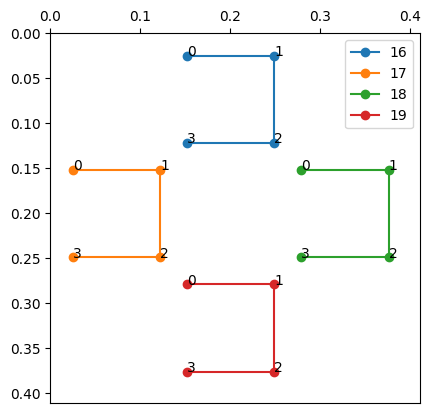

In [130]:
params = DiamondBoardParameter(0.097, 0.127)
markers = generate_diamond_corners((16, 17, 18, 19), params)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim((0, params.total_side_length))
ax.set_ylim((0, params.total_side_length)) # type: ignore
ax.set_aspect("equal")
# set origin to top-left (from bottom-left)
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')

for marker in markers:
    plt.plot(*marker.np_corners.T, "o-", label=str(marker.id))
    for i, (x, y) in enumerate(marker.corners):
        ax.text(x, y, str(i))
plt.legend()
plt.show()

In [131]:
from typing import Sequence
import plotly.graph_objects as go
import awkward as ak
import cv2
from cv2.typing import MatLike


def transform_point(matrix: MatLike, point: MatLike):
    assert matrix.shape == (4, 4)
    assert point.shape == (3,)

    # Lift point to 4D
    homogeneous_point = np.array([point[0], point[1], point[2], 1])
    # Apply transformation
    transformed = matrix @ homogeneous_point
    # Project back to 3D if w != 1
    if transformed[3] != 1:
        transformed = transformed / transformed[3]
    return transformed[:3]


class DiamondPlane3D:
    _ids: NDArray
    """
    (n,)
    """
    _corners: NDArray
    """
    (n, 4, 3)
    """
    _transform_matrix: NDArray
    """
    4x4 transformation matrix
    """
    _normal_vector: NDArray
    """
    (2, 3)
    start (the center of the plane) and end (the normal vector), length 1
    """

    def __init__(self, items: Sequence[ArUcoMarker2D]):
        self._ids = np.array([item.id for item in items])
        # (n, 4, 2)
        corners_2d = np.array([item.np_corners for item in items])
        # (n, 4, 3)
        self._corners = np.concatenate(
            [corners_2d, np.zeros((corners_2d.shape[0], 4, 1))], axis=-1
        )
        self._transform_matrix = np.eye(4)

        def center(items: Sequence[ArUcoMarker2D]):
            return np.mean([item.np_corners for item in items], axis=(0, 1))

        c = center(items)
        assert c.shape == (2,)
        self._normal_vector = np.array([(c[0], c[1], 0), (c[0], c[1], 0.1)])

    @property
    def ids(self):
        return self._ids

    @property
    def corners(self):
        return self._corners

    @property
    def transform_matrix(self):
        return self._transform_matrix

    @property
    def transformed_corners(self):
        def g():
            for corner in self.corners:
                yield np.array(
                    [transform_point(self.transform_matrix, c) for c in corner]
                )

        return np.array(list(g()))

    @property
    def transformed_normal_vector(self):
        def g():
            for v in self._normal_vector:
                yield transform_point(self.transform_matrix, v)

        return np.array(list(g()))

    @property
    def transformed_geometry_center(self):
        return np.mean(self.transformed_corners, axis=(0, 1))

    def local_rotate(self, angle: float, axis: NDArray):
        """
        rotate the plane by angle (in radian) around local center

        Args:
            angle: in radian
            axis: (3,)

        change basis to local basis, rotate, then change back
        """
        raise NotImplementedError

    def rotate(self, angle: float, axis: NDArray):
        """
        rotate the plane by angle (in radian) around the axis
        """
        assert axis.shape == (3,)
        rot_mat = cv2.Rodrigues(axis * angle)[0]
        self._transform_matrix[:3, :3] = np.dot(rot_mat, self._transform_matrix[:3, :3])

    def translate(self, vec: NDArray):
        """
        translate the plane by vec
        """
        assert vec.shape == (3,)
        self._transform_matrix[:3, 3] += vec

    def set_transform_matrix(self, mat: NDArray):
        assert mat.shape == (4, 4)
        self._transform_matrix = mat

In [132]:
plane_a = DiamondPlane3D(markers)

markers_b = generate_diamond_corners((20, 21, 22, 23), params)
plane_b = DiamondPlane3D(markers_b)
# plane_b.translate(np.array([0, 0, 0.1]))
plane_b.rotate(np.pi/2, np.array([1, 0, 0]))
plane_b.rotate(np.pi, np.array([0, 0, 1]))
tmp_c = plane_b.transformed_geometry_center
plane_b.translate(-tmp_c)
plane_b.rotate(np.pi, np.array([0, 1, 0]))
plane_b.translate(tmp_c)
plane_b.translate(np.array([0, 0, params.total_side_length]))

markers_c = generate_diamond_corners((24, 25, 26, 27), params)
plane_c = DiamondPlane3D(markers_c)
tmp = plane_c.transformed_geometry_center
plane_c.translate(-tmp)
plane_c.rotate(-np.pi/2, np.array([0, 0, 1]))
plane_c.translate(tmp)
plane_c.translate(np.array([0, params.total_side_length-params.border_length, 0]))
plane_c.rotate(np.pi/2, np.array([0, 1, 0]))
plane_c.translate(np.array([0, 0, params.total_side_length]))

In [134]:
fig = go.Figure()
t_corners = plane_a.transformed_corners
for i, corners in enumerate(t_corners):
    fig.add_trace(
        go.Scatter3d(
            x=corners[:, 0],
            y=corners[:, 1],
            z=corners[:, 2],
            mode="markers+lines+text",
            text=list(range(4)),
            name=str(plane_a.ids[i]),
            marker=dict(size=1),
        )
    )

print(plane_a.transformed_normal_vector)
# normal vector
fig.add_trace(
    go.Scatter3d(
        x=plane_a.transformed_normal_vector[:, 0],
        y=plane_a.transformed_normal_vector[:, 1],
        z=plane_a.transformed_normal_vector[:, 2],
        mode="markers+lines",
        name="normal_a",
        marker=dict(size=2),
    )
)

t_corners_b = plane_b.transformed_corners
for i, corners in enumerate(t_corners_b):
    fig.add_trace(
        go.Scatter3d(
            x=corners[:, 0],
            y=corners[:, 1],
            z=corners[:, 2],
            mode="markers+lines+text",
            text=str(plane_b.ids[i]),
            name=str(plane_b.ids[i]),
            marker=dict(size=1),
        )
    )
fig.add_trace(
    go.Scatter3d(
        x=plane_b.transformed_normal_vector[:, 0],
        y=plane_b.transformed_normal_vector[:, 1],
        z=plane_b.transformed_normal_vector[:, 2],
        mode="markers+lines",
        name="normal_b",
        marker=dict(size=2),
    )
)

t_corners_c = plane_c.transformed_corners
for i, corners in enumerate(t_corners_c):
    fig.add_trace(
        go.Scatter3d(
            x=corners[:, 0],
            y=corners[:, 1],
            z=corners[:, 2],
            mode="markers+lines+text",
            text=str(plane_c.ids[i]),
            name=str(plane_c.ids[i]),
            marker=dict(size=1),
        )
    )
fig.add_trace(
    go.Scatter3d(
        x=plane_c.transformed_normal_vector[:, 0],
        y=plane_c.transformed_normal_vector[:, 1],
        z=plane_c.transformed_normal_vector[:, 2],
        mode="markers+lines",
        name="normal_c",
        marker=dict(size=2),
    )
)

# fig.update_layout(
#     scene=dict(
#         aspectmode="cube",
#         yaxis_autorange="reversed",
#     )
# )

fig.update_layout(
    scene=dict(
        aspectmode='cube',
        xaxis=dict(range=[-0.1, params.total_side_length]),
        yaxis=dict(range=[params.total_side_length, -0.1]),
        zaxis=dict(range=[-0.1, params.total_side_length]),
    )
)
fig.show()

[[0.2005     0.20049998 0.        ]
 [0.2005     0.20049998 0.1       ]]
